In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import datetime

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
startTime = datetime.datetime.now()

In [ ]:
torch.manual_seed(190401094)

In [ ]:
batch_size = 16

In [ ]:
# Veri setlerini yükleme
train_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/yapaysiniraglari/cure_the_princess_validation.csv')

# Model eğitme
from torch.utils.data import DataLoader, TensorDataset
train_inputs = train_df.drop('Cured', axis=1).values
train_labels = train_df['Cured'].values
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))

val_inputs = val_df.drop('Cured', axis=1).values
val_labels = val_df['Cured'].values
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float), torch.tensor(val_labels, dtype=torch.long))

test_inputs = test_df.drop('Cured', axis=1).values
test_labels = test_df['Cured'].values
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Model tanımlama
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        #Ilk hidden layer’da 100, ikinci hidden layer’da 50 nöron olsun
        self.fc1 = nn.Linear(len(train_df.columns) - 1, 100) 
        self.fc2 = nn.Linear(100, 50) 
        self.fc3 = nn.Linear(50, 2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        output = nn.functional.relu(self.fc1(x))
        output = nn.functional.relu(self.fc2(output))
        output = self.fc3(output)
        return self.sigmoid(output)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyModel().to(device)

In [ ]:
#Loss function ve optimizer tanımlama
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Train function tanımlama
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, best_val_loss):
    for epoch in range(num_epochs):
       # Model eğitimi
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            #StartL1Reg
            # l1_loss = 0
            # for param in model.parameters():
            #     l1_loss += torch.sum(torch.abs(param))
            # loss += l1_reg * l1_loss
            #EndL1Reg

            #StartL2Reg
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += weight_decay * l2_reg
            #EndL2Reg

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_loss /= len(train_loader)
        train_accuracy = 100. * correct / total
        loss_list.append(train_loss)

       # Değerlendirme
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                #StartL1Reg
                # l1_loss = 0
                # for param in model.parameters():
                #     l1_loss += torch.sum(torch.abs(param))
                # loss += l1_reg * l1_loss
                #EndL1Reg

                #StartL2Reg
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param)
                loss += weight_decay * l2_reg
                # EndL2Reg

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_loss /= len(valid_loader)
        val_accuracy = 100. * val_correct / val_total
        val_loss_list.append(val_loss)

        #Early Stopping
        val_score=val_loss
        if best_val_loss is None:
          patience_counter=0
          best_val_loss=val_score       
          torch.save(model.state_dict(),"checkpoint.pt")
        elif best_val_loss < val_score:     
          patience_counter+=1
          print("Earlystopping Patience Counter",patience_counter)
          if patience_counter==patience:
            print("EARLYSTOPPED!")
            return epoch+2
        else:
          best_val_loss=val_score
          torch.save(model.state_dict(),"checkpoint.pt")       
          patience_counter=0       
    
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}")
        
l1_reg = 0.01 # L1 regularization katsayısı
weight_decay = 0.1  # L2 regularization katsayısı
num_epochs = 50
loss_list = []
val_loss_list = []
patience=5
best_val_loss = None
break_value=train(model, criterion, optimizer, train_loader, val_loader, num_epochs, best_val_loss)

Epoch [1/50], Train Loss: 1.9313, Train Acc: 53.99, Val Loss: 1.8594, Val Acc: 70.38
Epoch [2/50], Train Loss: 1.8188, Train Acc: 74.12, Val Loss: 1.7528, Val Acc: 80.25
Epoch [3/50], Train Loss: 1.7373, Train Acc: 79.71, Val Loss: 1.6798, Val Acc: 86.94
Epoch [4/50], Train Loss: 1.6785, Train Acc: 82.11, Val Loss: 1.6166, Val Acc: 89.49
Epoch [5/50], Train Loss: 1.6240, Train Acc: 84.03, Val Loss: 1.5708, Val Acc: 88.54
Epoch [6/50], Train Loss: 1.5861, Train Acc: 84.82, Val Loss: 1.5356, Val Acc: 92.04
Epoch [7/50], Train Loss: 1.5537, Train Acc: 85.54, Val Loss: 1.5195, Val Acc: 86.94
Epoch [8/50], Train Loss: 1.5259, Train Acc: 85.62, Val Loss: 1.4765, Val Acc: 92.36
Epoch [9/50], Train Loss: 1.4968, Train Acc: 86.90, Val Loss: 1.4498, Val Acc: 92.36
Epoch [10/50], Train Loss: 1.4691, Train Acc: 87.30, Val Loss: 1.4235, Val Acc: 92.36
Epoch [11/50], Train Loss: 1.4460, Train Acc: 87.94, Val Loss: 1.4109, Val Acc: 89.81
Epoch [12/50], Train Loss: 1.4217, Train Acc: 86.66, Val Loss: 

In [ ]:
from sklearn.metrics import  accuracy_score, precision_score, f1_score,recall_score

# Modeli değerlendirme modunda ayarla
model.eval()

# Test seti üzerinde döngüye gir ve tahminler yap
with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.cpu().numpy().tolist()
        predicted_labels += predicted.cpu().numpy().tolist()

# Performans metriklerini hesapla
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9093
Precision: 0.9109
Recall: 0.9093
F1 Score: 0.9093


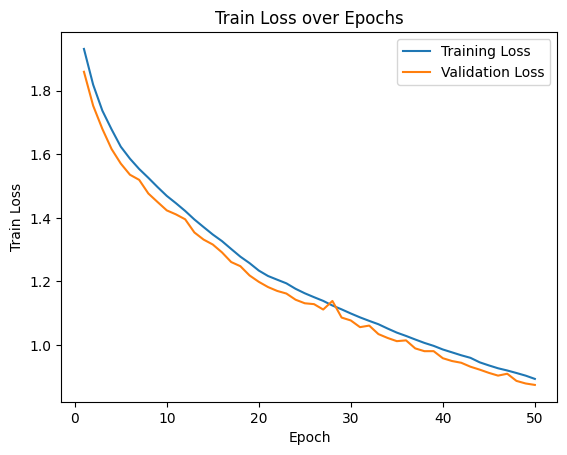

In [ ]:
# Train Loss over Epochs figürü çiz
plt.figure()
break_value = num_epochs+1 if break_value is None else break_value
plt.plot(range(1, break_value), loss_list, label= "Training Loss")
plt.plot(range(1, break_value), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
endTime = datetime.datetime.now()
print("Başlangıç Zamanı: ", endTime, "\nBitiş Zamanı: ", endTime, "\nToplam Çalışma Süresi:", endTime-startTime , "\nÇalışma Ortamı: ", str(device).upper())

Başlangıç Zamanı:  2023-04-09 11:49:30.221125 
Bitiş Zamanı:  2023-04-09 11:49:30.221125 
Toplam Çalışma Süresi: 0:00:10.220616 
Çalışma Ortamı:  CPU
